In [1]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
import optuna
import seaborn as sns

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load in 2022 mlb season data

df = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022_processed.csv")

# load in 2023 mlb season data

df_2023 = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2023_processed.csv")

In [3]:
# load in linear weights for events

linear_weights = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\linear_weights.csv")

In [4]:
# load in calculated expected metrics

xpfx_x = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\pfx_2022&3_xpfx.csv")
xpfx_z = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\IVB_2022&3_xpfz.csv")
xspin_axis = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\axis_2022&3_xaxis.csv")

xswing = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\swing_2022&3_xswing.csv")
xwhiff = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\whiff_2022&3_xwhiff.csv")
xfb = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\fb_2022&3_xfb.csv")
xgrb = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\gb_2022&3_xgb.csv")
xld = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\ld_2022&3_xld.csv")
xfoul = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\foul_2022&3_xfoul.csv")
xcs = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\cs_2022&3_xcalledstrike.csv")
diff2022 = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\2022_diffs.csv")
diff2023 = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\2023_diffs.csv")

In [5]:
# rename and drop columns from expected dfs

xpfx_x = xpfx_x[['pitch_id_raw', 'xpfx_x']]
xpfx_z = xpfx_z[['pitch_id_raw', 'xpfx_z']]
xspin_axis = xspin_axis[['pitch_id_raw', 'diff']]
xswing = xswing[['pitch_id_raw', 'xswing']]
xwhiff = xwhiff[['pitch_id_raw', 'xwhiff']]
xfb = xfb[['pitch_id_raw', 'xfb']]
xgrb = xgrb[['pitch_id_raw', 'xgb']]
xld = xld[['pitch_id_raw', 'xld']]
xfoul = xfoul[['pitch_id_raw', 'xfoul']]
xcs = xcs[['pitch_id_raw', 'xcs']]
diffs = pd.concat([diff2022, diff2023], axis=0)
diffs = diffs[['pitch_id_raw', 'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed']]

In [6]:
# ensure df is sequential

df.sort_values(by=['game_pk', 'inning', 'at_bat_number', 'pitch_number'], inplace=True)

# convert batter handedness columns to binary

stand_encoder = LabelEncoder()
all_stand = pd.concat([df['stand'], df_2023['stand']]).unique()
stand_encoder.fit(all_stand)

df['stand'] = stand_encoder.transform(df['stand'])

# generate unique id column

df['pitch_id_raw'] = df['game_pk'].astype(str) + "_" + \
                            df['batter'].astype(str) + "_" + \
                            df['pitcher'].astype(str) + "_" + \
                            df['pitch_number'].astype(str) + "_" + \
                            df['at_bat_number'].astype(str) + "_" + \
                            df['inning'].astype(str)

# select only offspeed

df = df[df['pitch_type'].isin(['CH', 'FS'])]

# normalize LHP values to RHP standards

df.loc[df['p_throws'] == 'L', 'pfx_x'] = df['pfx_x'] * -1
df.loc[df['p_throws'] == 'L', 'release_pos_x'] = df['release_pos_x'] * -1
df.loc[df['p_throws'] == 'L', 'spin_axis'] = 360 - df['spin_axis']

# total movement column

df['pfx_total'] = abs(df['pfx_x']) + abs(df['pfx_z'])

# movement ratio column

df['pfx_x_ratio'] = abs(df['pfx_x']) / df['pfx_total']
df['pfx_z_ratio'] = abs(df['pfx_z']) / df['pfx_total']

In [7]:
# ensure df is sequential

df_2023.sort_values(by=['game_pk', 'inning', 'at_bat_number', 'pitch_number'], inplace=True)

# convert batter handedness columns to binary

df_2023['stand'] = stand_encoder.transform(df_2023['stand'])

# generate unique id column

df_2023['pitch_id_raw'] = df_2023['game_pk'].astype(str) + "_" + \
                            df_2023['batter'].astype(str) + "_" + \
                            df_2023['pitcher'].astype(str) + "_" + \
                            df_2023['pitch_number'].astype(str) + "_" + \
                            df_2023['at_bat_number'].astype(str) + "_" + \
                            df_2023['inning'].astype(str)

# select only offspeed

df_2023 = df_2023[df_2023['pitch_type'].isin(['CH', 'FS'])]

# normalize LHP values to RHP standards

df_2023.loc[df_2023['p_throws'] == 'L', 'pfx_x'] = df_2023['pfx_x'] * -1
df_2023.loc[df_2023['p_throws'] == 'L', 'release_pos_x'] = df_2023['release_pos_x'] * -1
df.loc[df['p_throws'] == 'L', 'spin_axis'] = 360 - df['spin_axis']

# total movement column
df_2023['pfx_total'] = abs(df_2023['pfx_x']) + abs(df_2023['pfx_z'])

# movement ratio column
df_2023['pfx_x_ratio'] = abs(df_2023['pfx_x']) / df_2023['pfx_total']
df_2023['pfx_z_ratio'] = abs(df_2023['pfx_z']) / df_2023['pfx_total']

In [8]:
pitch_type_map = {
        "FF": "FF", "FT": "SI", "FC": "CT",
        "SL": "SL", "ST": "SL", "SV": "SL",
        "CH": "CH", "FS": "SP",
        "CU": "CB", "KC": "CB", "CS": "CB", "CB": "CB",
        "SI": "SI", "KN": "KN", "FA": "FF", "FT": "SI"
    }

df_2023['pitch_type'] = df_2023['pitch_type'].map(pitch_type_map)
df['pitch_type'] = df['pitch_type'].map(pitch_type_map)

In [9]:
# create outcome column using events and description columns

events_mapping = {
    'field_out': 'field_out',
    'force_out': 'field_out',
    'fields_choice_out': 'field_out',
    'fielders_choice': 'field_out',
    'other_out': 'field_out',
    'sac_fly': 'field_out',
    'sac_bunt': 'field_out',
    'walk': 'walk',
    'hit_by_pitch': 'walk',
    'strikeout': 'strikeout',
    'grounded_into_double_play': 'double_play',
    'double_play': 'double_play',
    'strikeout_double_play': 'double_play',
    'sac_fly_double_play': 'double_play',
    'single': 'single',
    'double': 'double',
    'triple': 'triple',
    'home_run': 'home_run'    
}


description_mapping = {
    'ball': 'ball',
    'called_strike': 'strike',
    'foul': 'foul',
    'swinging_strike': 'strike',
    'foul_tip': 'foul',
    'hit_by_pitch': 'walk',
    'blocked_ball': 'ball' ,
    'missed_bunt': 'strike',
    'foul_bunt': 'foul',
    'swinging_strike_blocked': 'strike',
    'bunt_foul_tip': 'foul'
}

In [10]:
# function for using mappings to determine outcome

def determine_outcome(row):
    
    event = row['events']
    description = row['description']
    
    if event in events_mapping:
        return events_mapping[event]

    elif description in description_mapping:
        return description_mapping[description]

    else:
        return np.nan

# apply function to each row

df['outcome'] = df.apply(determine_outcome, axis=1)
df_2023['outcome'] = df_2023.apply(determine_outcome, axis=1)

In [11]:
# drop na outcome rows

df.dropna(subset=['outcome'], inplace=True)
df_2023.dropna(subset=['outcome'], inplace=True)

In [12]:
# create outcome label encoder

outcome_encoder = LabelEncoder()

# get all possible outcome values

all_outcome = pd.concat([df['outcome'], df_2023['outcome']]).unique()
outcome_encoder.fit(all_outcome)

# label encode the outcome column

df['outcome'] = outcome_encoder.transform(df['outcome'])
df_2023['outcome'] = outcome_encoder.transform(df_2023['outcome'])

In [13]:
# perform left joins

df = pd.merge(df, xpfx_x, on='pitch_id_raw', how='left')
df = pd.merge(df, xpfx_z, on='pitch_id_raw', how='left')
df = pd.merge(df, xspin_axis, on='pitch_id_raw', how='left')
df = pd.merge(df, xswing, on='pitch_id_raw', how='left')
df = pd.merge(df, xwhiff, on='pitch_id_raw', how='left')
df = pd.merge(df, xfb, on='pitch_id_raw', how='left')
df = pd.merge(df, xgrb, on='pitch_id_raw', how='left')
df = pd.merge(df, xld, on='pitch_id_raw', how='left')
df = pd.merge(df, xfoul, on='pitch_id_raw', how='left')
df = pd.merge(df, xcs, on='pitch_id_raw', how='left')
df = pd.merge(df, diffs, on='pitch_id_raw', how='left')

In [14]:
# perform left joins

df_2023 = pd.merge(df_2023, xpfx_x, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xpfx_z, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xspin_axis, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xswing, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xwhiff, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xfb, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xgrb, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xld, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xfoul, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xcs, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, diffs, on='pitch_id_raw', how='left')

In [15]:
# convert all negative swing probabilities to zero (bug)

df.loc[df['xswing'] < 0, 'xswing'] = 0
df_2023.loc[df_2023['xswing'] < 0, 'xswing'] = 0

In [16]:
# create combination term of swing and whiff probabilities

df['swing_whiff'] = df['xswing'] * df['xwhiff']
df_2023['swing_whiff'] = df_2023['xswing'] * df_2023['xwhiff']

In [17]:
# feature selection and data splitting

columns = ['outcome', 'player_name', 'pitch_type', 'spin_axis', 'ax', 'vz0', 'az', 'vx0', 'ay', 'vy0', 'release_speed', 'release_pos_x', 'release_pos_y', \
           'release_pos_z', 'release_extension', 'release_spin_rate', 'pfx_z', 'pfx_x', 'pfx_total', 'pfx_x_ratio', 'pfx_z_ratio',\
           'xpfx_x', 'xpfx_z', 'diff', 'xwhiff', 'xswing', 'swing_whiff', 'xfb', 'xgb', 'xld', 'xfoul', 'xcs', 'delta_run_exp', 'rolling_avg_velo', 'diff_spin_axis',\
           'diff_pfx_x', 'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed']

features = ['spin_axis', 'ax', 'vz0', 'az', 'vx0', 'ay', 'vy0', 'release_speed', 'release_pos_x', 'release_pos_y', \
           'release_pos_z', 'release_extension', 'release_spin_rate', 'pfx_z', 'pfx_x', 'pfx_total', 'pfx_x_ratio', 'pfx_z_ratio',\
           'xpfx_x', 'xpfx_z', 'diff', 'xwhiff', 'xswing', 'swing_whiff', 'xfb', 'xgb', 'xld', 'xfoul', 'xcs', 'rolling_avg_velo', 'diff_spin_axis',\
            'diff_pfx_x', 'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed']

# drop any rows with nan values

df = df[columns]
df = df.dropna()

# create features and targets

X = df[features]
y = df['outcome']

In [18]:
# train valid test split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# optuna tuning block

#def objective(trial):
    
    # define hyperparameters
    
    #params = {
        #'max_depth': trial.suggest_int('max_depth', 3, 9),
        #'learning_rate': trial.suggest_float('eta', 0.01, 0.3),
        #'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        #'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        #'objective': 'multi:softmax',
        #'num_class': len(np.unique(y_train)),
        #'eval_metric': 'mlogloss',
        #'use_label_encoder': False
    #}

    # initialize model
    
    #model = xgb.XGBClassifier(**params, n_estimators=100)

    # train the model
    
    #model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=50, verbose=False)

    # predict on validation set
    
    #y_valid_pred = model.predict_proba(X_valid)

    # calculate log loss on the validation set
    
    #loss = log_loss(y_valid, y_valid_pred)

    #return loss

#create an optuna study and specifcy the the direction of the optimization

#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=100)

# print best parameters

#print(study.best_params)

In [20]:
# set up model

params = {
        'max_depth': 6,
        'eta': 0.1044289896836109,
        'subsample': 0.8838491939084707,
        'colsample_bytree': 0.9518679684601651,
        'objective': 'multi:softmax',
        'num_class': len(np.unique(y_train)),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

# initialize model
    
model = xgb.XGBClassifier(**params, n_estimators=100)

# train model

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9518679684601651, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.1044289896836109, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=11, ...)

In [21]:
# make predictions

y_pred = model.predict(X_valid)

# evaluate the model

accuracy = accuracy_score(y_valid, y_pred)
conf_matrix = confusion_matrix(y_valid, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.4891598168477961
Confusion Matrix:
[[6089    0    0   61  257    0    4  428   16    0    0]
 [  27    7    0   74   38    0   48   56    0    0    0]
 [  31    0    0    5   40    0    4   36    0    0    0]
 [ 488   10    0  187  810    0   96  725    5    0    0]
 [ 769    0    0  143 1048    0   16  995   14    0    0]
 [  12    0    0    9   43    0    2   53    0    0    0]
 [ 167   10    0  144  151    0  128  140    0    0    0]
 [ 867    0    0  157  843    0   15 1391   12    0    0]
 [ 607    1    0   30  208    0    2  279   17    0    0]
 [   0    0    0    7    2    0    3    2    0    0    0]
 [ 271    0    0    0    8    0    0   18    1    0    0]]


<Figure size 1000x5000 with 0 Axes>

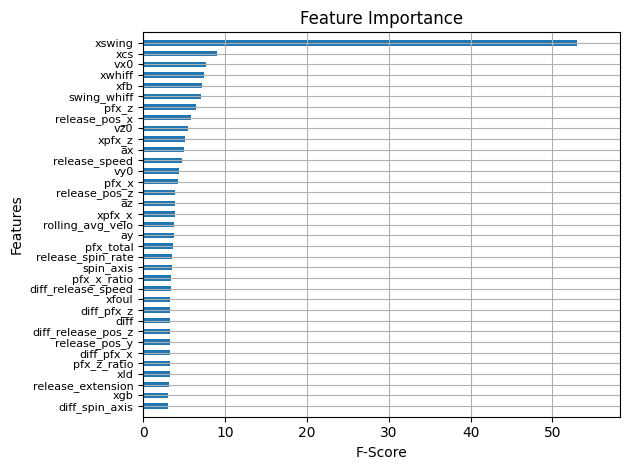

In [22]:
# plot feature importance

plt.figure(figsize=(10, 50))
xgb.plot_importance(model, importance_type='gain', show_values=False, height=0.5)
plt.title('Feature Importance')
plt.xlabel('F-Score')
plt.ylabel('Features')
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig('os_feature_importance.png', dpi=300)
plt.show()

In [23]:
# get feature importance dictionary

importance = model.get_booster().get_score(importance_type='gain')

# sort features by importance

sorted_importance = sorted(importance.items(), key=lambda item: item[1], reverse=True)

# loop to print

for feature, score in sorted_importance:
    print(f'{feature}: {score}')

xswing: 52.95700454711914
xcs: 8.964503288269043
vx0: 7.625217914581299
xwhiff: 7.482027530670166
xfb: 7.216343402862549
swing_whiff: 7.071905612945557
pfx_z: 6.418598651885986
release_pos_x: 5.824326515197754
vz0: 5.423555374145508
xpfx_z: 5.131004810333252
ax: 5.029571056365967
release_speed: 4.744978904724121
vy0: 4.439148902893066
pfx_x: 4.283723831176758
release_pos_z: 3.9380810260772705
az: 3.8914906978607178
xpfx_x: 3.850440740585327
rolling_avg_velo: 3.822767734527588
ay: 3.7893130779266357
pfx_total: 3.656484842300415
release_spin_rate: 3.5315046310424805
spin_axis: 3.5264337062835693
pfx_x_ratio: 3.445589780807495
diff_release_speed: 3.366626739501953
xfoul: 3.3314337730407715
diff_pfx_z: 3.3165035247802734
diff: 3.2824161052703857
diff_release_pos_z: 3.2630856037139893
release_pos_y: 3.2591705322265625
diff_pfx_x: 3.2438712120056152
pfx_z_ratio: 3.2426092624664307
xld: 3.225554943084717
release_extension: 3.130532741546631
xgb: 3.075279951095581
diff_spin_axis: 3.06616878509

In [24]:
# copy and keep only features

df_2023_features = df_2023[features]

# generate outcome probabilities on 2023 mlb season data

outcome_probabilities = model.predict_proba(df_2023_features)

# apply outcome probabilities back onto full df

for i, class_label in enumerate(model.classes_):
    df_2023[f'prob_{class_label}'] = outcome_probabilities[:, i]

In [25]:
# label encode linear weights to match outcome

linear_weights = linear_weights[linear_weights['description'] != 'caught_stealing_2b']
linear_weights['outcome'] = outcome_encoder.transform(linear_weights['description'])

In [26]:
linear_weight_values = linear_weights.set_index('outcome')['linear_weight']

# weighted sum of each outcome's probability * each outcome's linear weight run value

df_2023['pitch_quality'] = sum(
    df_2023[f'prob_{i}'] * linear_weight_values[i] for i in range(11)
)

In [27]:
def reformat_name(name):
    parts = name.split(', ')
    if len(parts) == 2:
        return parts[1] + ' ' + parts[0]
    else:
        return name

df['player_name'] = df['player_name'].apply(reformat_name)
df_2023['player_name'] = df_2023['player_name'].apply(reformat_name)

In [28]:
# group by player name and pitch type for pitches a player threw more than 100 times

grouped_data = df_2023.groupby(['player_name', 'pitch_type']).filter(lambda x: len(x) > 100)

# group by player name and pitch type and get the mean pitch quality

pitch_quality_sum = grouped_data.groupby(['player_name', 'pitch_type'])['pitch_quality'].mean().reset_index()

# sort the results by pitch quality in descending order and take the top 10

bottom_10 = pitch_quality_sum.sort_values(by='pitch_quality', ascending=False).head(10)

# sort the results by pitch quality in ascending order and take the bottom 10

top_10 = pitch_quality_sum.sort_values(by='pitch_quality', ascending=True).head(10)

# print results

print("Top 10:")
print(top_10)
print("\nBottom 10:")
print(bottom_10)

Top 10:
           player_name pitch_type  pitch_quality
89      Félix Bautista         SP      -0.036659
123        Jhoan Duran         SP      -0.034457
240  Shintaro Fujinami         SP      -0.034314
167      Kyle Finnegan         SP      -0.033655
87      Framber Valdez         CH      -0.024878
244        Steven Matz         CH      -0.024196
271     Yonny Chirinos         SP      -0.023819
198      Michael Wacha         CH      -0.023273
233    Sandy Alcantara         CH      -0.022551
124        Jhony Brito         CH      -0.022447

Bottom 10:
        player_name pitch_type  pitch_quality
171     Kyle Muller         CH       0.019516
85       Eury Pérez         CH       0.017468
196  Michael Kopech         CH       0.015395
75       Drew Smith         CH       0.013925
51    Chris Bassitt         SP       0.013300
61   Connor Seabold         CH       0.012563
104   Hunter Greene         CH       0.011390
27     Brady Singer         CH       0.010608
132    Johan Oviedo        

In [29]:
# determine max and min avg pitch quality values

max_val = pitch_quality_sum['pitch_quality'].max()
min_val = pitch_quality_sum['pitch_quality'].min()

# create normalized stuff+ metric centered around 100

pitch_quality_sum['stuff_plus'] = max_val - pitch_quality_sum['pitch_quality']
mean_stuff = pitch_quality_sum['stuff_plus'].mean()
scaling_factor = 100 / mean_stuff
pitch_quality_sum['stuff_plus'] = pitch_quality_sum['stuff_plus'] * scaling_factor
pitch_quality_sum['stuff_plus'] += 100 - pitch_quality_sum['stuff_plus'].mean()

# sort by stuff plus in ascending order

sorted_pitch_quality_sum = pitch_quality_sum.sort_values(by='stuff_plus', ascending=False)

# reset index and +1 to get rank column

sorted_pitch_quality_sum = sorted_pitch_quality_sum.reset_index()
sorted_pitch_quality_sum.index = sorted_pitch_quality_sum.index + 1

# convert to int for rounding

sorted_pitch_quality_sum['stuff_plus'] = sorted_pitch_quality_sum['stuff_plus'].astype(int)

# print name, pitch type, and stuff plus top 50

sorted_pitch_quality_sum[['player_name', 'pitch_type', 'stuff_plus']].head(50)

,player_name,pitch_type,stuff_plus
1,Félix Bautista,SP,219
2,Jhoan Duran,SP,211
3,Shintaro Fujinami,SP,210
4,Kyle Finnegan,SP,207
5,Framber Valdez,CH,173
6,Steven Matz,CH,170
7,Yonny Chirinos,SP,169
8,Michael Wacha,CH,167
9,Sandy Alcantara,CH,164
10,Jhony Brito,CH,164


In [30]:
# select top 25 rows

top_25_rows = sorted_pitch_quality_sum[['player_name', 'pitch_type', 'stuff_plus']].head(25)

# plotting rankings as a table

fig, ax = plt.subplots(figsize=(5, 6))
ax.axis('tight')
ax.axis('off')
ax.set_title('Top 25 Offspeed Stuff+')
table = ax.table(cellText=top_25_rows.values,
                 colLabels=top_25_rows.columns,
                 loc='center',
                 cellLoc='center',
                 colLoc='center',
                 colWidths=[0.4, 0.2, 0.2])
plt.tight_layout()

# save fig and close

plt.savefig('os_stuff_plus_rankings.png', dpi=300)
plt.close()

In [31]:
# group by pitcher and pitch type

pp = df_2023.groupby(['player_name', 'pitch_type'])

# calculate sum of delta run expectancy and count of pitches for each pitcher's pitch

rv = pp.agg(total_delta_run_exp=('delta_run_exp', 'sum'),
                      total_pitches=('delta_run_exp', 'count'))

# calculate run value per 100 pitches

rv['run_value_per_100_pitches'] = (rv['total_delta_run_exp'] / rv['total_pitches']) * 100

# filter for pitches thrown at least 100 times and sort

rv = rv[rv['total_pitches'] > 100]
rv = rv.sort_values(by='run_value_per_100_pitches')

# merge with sorted pitch quality sum on player name and pitch type

model_validation_df = pd.merge(sorted_pitch_quality_sum, rv, on=['player_name', 'pitch_type'], how='left')

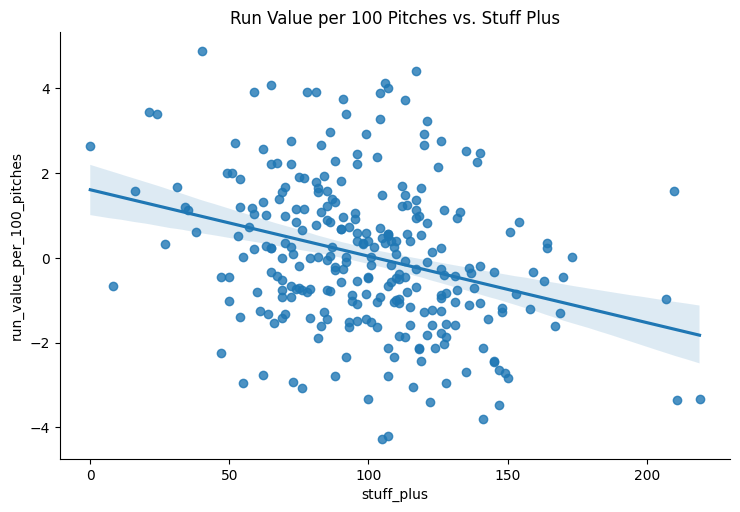

In [32]:
# scatter plot with a regression line

sns.lmplot(x='stuff_plus', y='run_value_per_100_pitches', data=model_validation_df, aspect=1.5)
plt.title('Run Value per 100 Pitches vs. Stuff Plus')
plt.savefig('os_validation_plot_os.png', dpi=300)
plt.show()

In [33]:
# correlation coefficient

correlation = model_validation_df['stuff_plus'].corr(model_validation_df['run_value_per_100_pitches'])
print(f"Correlation Coefficient: {correlation}")


from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score

slope, intercept, r_value, p_value, std_err = stats.linregress(model_validation_df['stuff_plus'], model_validation_df['run_value_per_100_pitches'])
predicted_values = slope * model_validation_df['stuff_plus'] + intercept

# mse and rmse

mse = mean_squared_error(model_validation_df['run_value_per_100_pitches'], predicted_values)
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

# rsquared

r_squared = r2_score(model_validation_df['run_value_per_100_pitches'], predicted_values)
print(f"R-squared: {r_squared}")

Correlation Coefficient: -0.30395775389212354
Mean Squared Error: 2.801956994269013
Root Mean Squared Error: 1.673904714811752
R-squared: 0.09239031615114501


In [34]:
# get pitch count for each pitcher's pitches

pitch_counts = df_2023.groupby(['player_name', 'pitch_type']).size()
count_df = pitch_counts.reset_index(name='count')

# merge pitch counts on pitch quality sum to get stuff plus and pitch count on the same df

os_clean = pd.merge(pitch_quality_sum, count_df, on=['player_name', 'pitch_type'], how='left')
os_clean['stuff_plus'] = os_clean['stuff_plus'].astype(int)
os_clean = os_clean[['player_name', 'pitch_type', 'stuff_plus', 'count']]
offspeed_ready = os_clean.sort_values(by='stuff_plus', ascending=False)
offspeed_ready = offspeed_ready.reset_index(drop=True)
offspeed_ready.index = offspeed_ready.index + 1

In [35]:
# save to y drive

offspeed_ready.to_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\polished_dfs\offspeed_ready.csv")